Figure3 (Referenced from  "Persistent effect of El Niño on global economic growth," by Christopher Callahan and Justin Mankin, published in _Science_, May 2023. https://github. com/ccallahan45/CallahanMankin_ENSOEconomics/.)

In [4]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as sr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
disease="Scrubtyphus" 
phase = "ENSO"
enso_var ="e_e-and-c"
response ="log_rate"
exclude_iso =["140000","150000","220000","310000","620000","630000","640000","650000","230000","540000","130000",'120000']
nlag =6
filter="100"
running_month="4"
tc_metric = "t_p_corr_running_e"

In [ ]:
loc_a="Data/Cumulative_effect/Province/"
loc_b="Data/Cumulative_effect/Teleconnections/"
loc_c="Data/Cumulative_effect/Lag/"
loc_shp = "E:/code/python/CallahanMankin_ENSOEconomics-main/china/"
loc_panel = "Data/Panel/"

In [ ]:
y1 = 2002
y2 = 2022
shp = gp.read_file(loc_shp+"China.shp")
iso_shp = shp.DZM.values
boundary=gp.read_file(loc_shp+"nine_line.shp.shp")

In [ ]:
panel = pd.read_csv(loc_panel+disease+"ENSO_Growth_Panel_"+str(y1)+"-"+str(y2)+".csv",index_col=0,encoding="GBK")
panel["iso"] = panel["iso"].values.astype(str)   
panel_s= panel[~panel['iso'].isin(exclude_iso)] 
panel_corrs = np.unique(panel_s[tc_metric].values) 

In [ ]:
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
def find_x_intersections(ax, xticks):
    x0, x1, y0, y1 = ax.get_extent()
    lon0, lon1, lat0, lat1 = ax.get_extent(ccrs.PlateCarree())
    xaxis = sgeom.LineString([(x0, y1), (x1, y1)])
    lon_ticks = [tick for tick in xticks if tick >= lon0 and tick <= lon1]

    nstep =50
    xlocs = []
    xticklabels = []
    for tick in lon_ticks:
        lon_line = sgeom.LineString(
            ax.projection.transform_points(
                ccrs.Geodetic(),
                np.full(nstep, tick),
                np.linspace(lat0, lat1, nstep)
            )[:, :2]
        )
  
        if xaxis.intersects(lon_line):
            point = xaxis.intersection(lon_line)
            xlocs.append(point.x)
            xticklabels.append(tick)
        else:
            continue


    formatter = LongitudeFormatter()
    xticklabels = [formatter(label) for label in xticklabels]

    return xlocs, xticklabels

def find_y_intersections(ax, yticks):
    x0, x1, y0, y1 = ax.get_extent()
    lon0, lon1, lat0, lat1 = ax.get_extent(ccrs.PlateCarree())
    yaxis = sgeom.LineString([(x0, y0), (x0, y1)])
    lat_ticks = [tick for tick in yticks if tick >= lat0 and tick <= lat1]

    nstep = 50
    ylocs = []
    yticklabels = []
    for tick in lat_ticks:
        lat_line = sgeom.LineString(
            ax.projection.transform_points(
                ccrs.Geodetic(),
                np.linspace(lon0, lon1, nstep),
                np.full(nstep, tick)
            )[:, :2]
        )
        if yaxis.intersects(lat_line):
            point = yaxis.intersection(lat_line)
            ylocs.append(point.y)
            yticklabels.append(tick)
        else:
            continue

    formatter = LatitudeFormatter()
    yticklabels = [formatter(label) for label in yticklabels]

    return ylocs, yticklabels

def set_lambert_ticks(ax, xticks, yticks):
    '''
    Parameters
    ----------
    ax : GeoAxes

    xticks : list of floats

    yticks : list of floats

    Returns
    -------
    None
    '''
  
    xlocs, xticklabels = find_x_intersections(ax, xticks)
    x110 = ax.projection.transform_point(110, 56, ccrs.PlateCarree())[0]
    xlocs.append(x110)
    xticklabels.append('110°E')
    ax.xaxis.set_ticks_position('top') 
    ax.set_xticks(xlocs)
    ax.set_xticklabels(xticklabels)
  

    ylocs, yticklabels = find_y_intersections(ax, yticks)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(yticklabels)

Plot e

不受e影响省份:16个


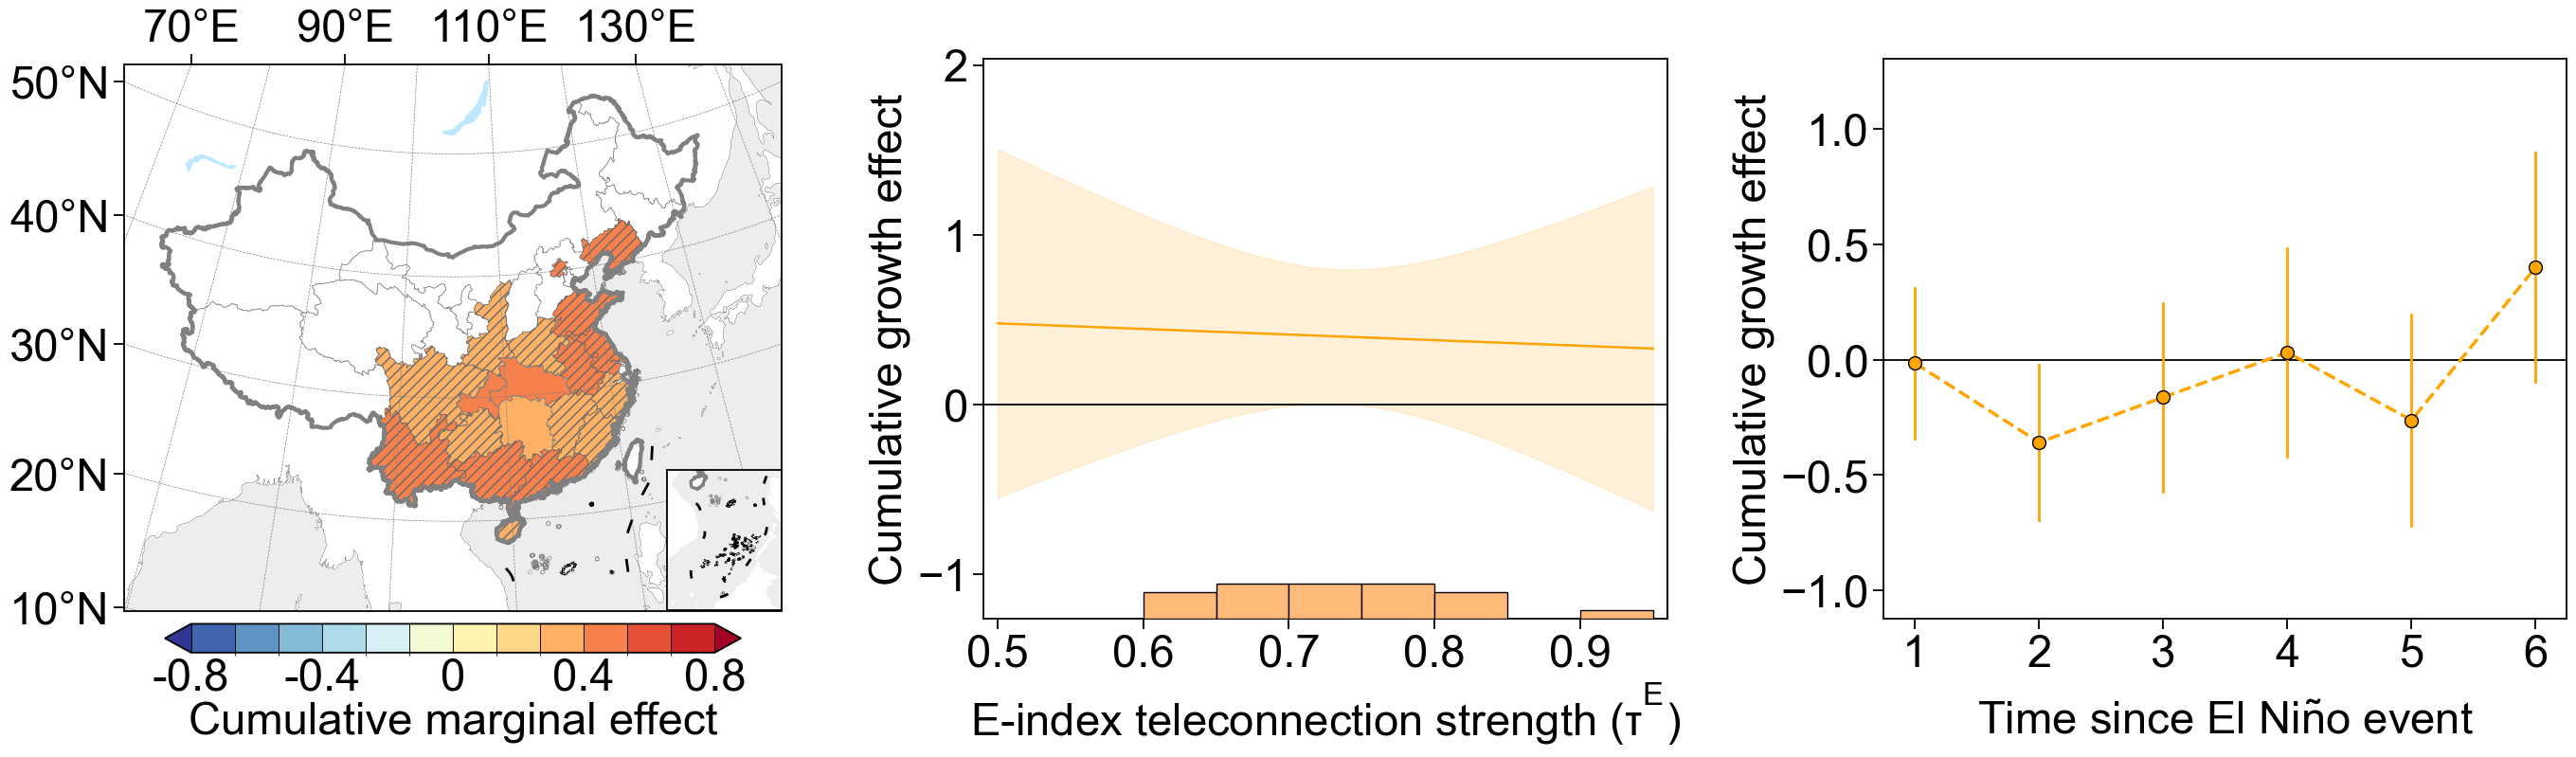

In [ ]:
from tkinter import font
fig = plt.figure(figsize=(27.2,7.8))
rcParams["font.family"] = "Arial" 
rcParams["font.size"] = 34
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

jitter = 0.15 
tfs = 34   


gs1 = gridspec.GridSpec(1,3)  #
gs1.update(left=0.03,right=0.98,top=0.92,bottom=0.03,wspace=0.2)  #,hspace=0.23) 

############################################################ marginal effects map
map_proj = ccrs.LambertConformal(
    central_longitude=105, central_latitude=40,standard_parallels=(25, 47)
)

ax = plt.subplot(gs1[0],projection=map_proj)  
ax.set_extent([79,131,13,55],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2,edgecolor="#969696")
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
ax.add_feature(cfeature.LAKES.with_scale('110m'), facecolor='#BEE8FF')  


ax.gridlines(
    xlocs=np.arange(-180, 180 + 1, 10), ylocs=np.arange(-90, 90 + 1, 10),
    draw_labels=False, x_inline=False, y_inline=False,
    linewidth=0.5, linestyle='--', color='gray'
)

set_lambert_ticks(ax, np.arange(70, 131, 20), np.arange(10, 59, 10))


cmin =-0.8 
cmax=0.8
nrange = 13
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

geom = sr.Reader(loc_shp+"China.shp").geometries()   # china_shp
boundary = sr.Reader(loc_shp+"nine_P.shp").geometries()  # china_nine-dashed line
ax.add_geometries(geom,ccrs.PlateCarree(),linestyle='-',facecolor="none",linewidth=0.5,edgecolor='grey')  
ax.add_geometries(boundary,ccrs.PlateCarree(),facecolor="none",edgecolor="black",linewidth=2)

file_a=pd.read_csv(loc_a+disease+"_e.csv",encoding="GBK")
file_a.iso = file_a.iso.astype(str)
sig_no_e=0
for i in file_a.iso:
    if i in iso_shp:
        val=file_a.loc[file_a.iso==i,"estimate_e"].values[0]
        upper=file_a.loc[file_a.iso==i,"upper_ci_e"].values[0]
        lower=file_a.loc[file_a.iso==i,"lower_ci_e"].values[0]
        sig=file_a.loc[file_a.iso==i,"sig"].values[0]
        if ((~np.isnan(val)) & (sig==1)):
                ax.add_geometries(shp.loc[shp["DZM"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="grey",linewidth=0.5)
        elif ((~np.isnan(val)) & (sig==0)):
            ax.add_geometries(shp.loc[shp["DZM"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="#686868",linewidth=0.5,
                             hatch="///")
            sig_no_e=sig_no_e+1
        else:
            ax.add_geometries(shp.loc[shp["DZM"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor="white",edgecolor="grey",linewidth=0.5)
    else:
         ax.add_geometries(shp.loc[shp["DZM"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor="grey",edgecolor="grey",linewidth=0.5)  

geom_china = sr.Reader(loc_shp+"china.shp").geometries() 
ax.add_geometries(geom_china,ccrs.PlateCarree(),facecolor="none",linewidth=3,edgecolor='gray', zorder=2)  
print("不受e影响省份:"+str(sig_no_e)+"个")

cb = fig.colorbar(cbar,ax=ax,orientation="horizontal",   
                 drawedges=True,extend="both",
                 shrink=0.8,aspect=20,pad=0.02,  
                 ticks=np.linspace(cmin,cmax,5))         
cb.ax.tick_params(direction="in",width=0.05,size=22) 
cb.set_label("Cumulative marginal effect",rotation=0,labelpad=2.6)   



ax5=fig.add_axes([0.205,0.182,0.14,0.19],projection=map_proj) 
ax5.set_extent([105, 119.5, 2, 20],crs=ccrs.PlateCarree())
ax5.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
boundary = sr.Reader(loc_shp+"nine_line.shp.shp").geometries()
geom_china = sr.Reader(loc_shp+"china.shp").geometries()  
ax5.add_geometries(boundary,ccrs.PlateCarree(),facecolor="none",edgecolor='black',linewidth=2)
ax5.add_geometries(geom_china,ccrs.PlateCarree(),facecolor="none",linewidth=2,edgecolor='gray', zorder=1)


####################################################### now marginal effects by teleconnection
ax2= fig.add_axes([0.3755, 0.17, 0.2655, 0.758])
lag5_col ="orange" 
lag1_lt = "-"
alph = 0.15

file_b=pd.read_csv(loc_b+disease+"_cumulative_effect_95%_e.csv",encoding="GBK")
corrs = file_b["tele_e"].values
mn=file_b["estimate_e"].values
upper=file_b["upper_ci_e"].values
lower=file_b["lower_ci_e"].values
plt.plot(corrs,mn,color=lag5_col,linewidth=1.8,label=str(nlag) +" lags",
        zorder=1,linestyle=lag1_lt)
ax2.fill_between(corrs,lower,upper,
                color="#ffa500",
                alpha=alph,zorder=1)

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-")
plt.ylabel("Cumulative growth effect")    # (cases per 100,000 pop.)
plt.xlabel("E-index teleconnection strength ("+r"$\tau^E$)")
xl = [0.49,0.96]
plt.xlim(xl)

inset_ax = fig.add_axes([0.3755,0.17,0.2655,0.24])   
bns = np.arange(0.5,1,0.05)
inset_ax.hist(panel_corrs,color="#ffb978",    
              linewidth=1,edgecolor="black",bins=bns) 

inset_ax.spines["right"].set_visible(True)
inset_ax.spines["top"].set_visible(False)
inset_ax.set_xlim(xl)
inset_ax.set_ylim([0,20])
inset_ax.spines["bottom"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.set_yticks([])
inset_ax.set_xticks([])
inset_ax.patch.set_alpha(0)

ax3= fig.add_axes([0.725, 0.17, 0.265, 0.758])
file_c=pd.read_csv(loc_c+disease+"_e.csv",encoding="GBK")

me_mean=file_c.groupby("lag")["estimate_e"].mean()
me_upper=file_c.groupby("lag")["upper_ci_e"].mean()
me_lower=file_c.groupby("lag")["lower_ci_e"].mean()
col ="orange"

lags1 = np.arange(1,nlag+1,1)
plt.plot(lags1,me_mean,color=col,markersize=10,
        zorder=3,marker="o",linestyle="--",linewidth=2.5,
        markerfacecolor=col,markeredgecolor="black")

for l in np.arange(0,nlag,1):
    plt.plot([(l+1),(l+1)],[me_lower[l+1],me_upper[l+1]],
            color=col,linewidth=2,linestyle="-",zorder=2)

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-",zorder=1)
plt.xticks(np.arange(1,nlag+1,1))      


plt.ylabel("Cumulative growth effect")   # (cases per 100,000 pop.)
plt.xlabel("Time since El Ni${\~n}$o event",labelpad=20)

# folder_path = "Figures\\Fig5\\" 
# if not os.path.exists(folder_path):
#         os.makedirs(folder_path)
# plt.savefig(folder_path+disease+str(nlag)+"_e.jpg",dpi=600)

plt.show()